In [368]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

Bernoulli = tf.contrib.distributions.Bernoulli
st = tf.contrib.bayesflow.stochastic_tensor

data = input_data.read_data_sets("MNIST_data/", one_hot=True).test
data.images[data.images>0.5] = 1.0
data.images[data.images<=0.5] = 0.0

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [533]:
def add_layer(inputs, wn, bn, in_dim, out_dim, af=None):
    try:
        w = tf.get_variable(wn, [in_dim, out_dim], initializer=tf.truncated_normal_initializer)
        b = tf.get_variable(bn, [1, out_dim], initializer=tf.truncated_normal_initializer)
    except:
        with tf.variable_scope(tf.get_variable_scope(), reuse=True):
            w = tf.get_variable(wn, [in_dim, out_dim], initializer=tf.truncated_normal_initializer)
            b = tf.get_variable(bn, [1, out_dim], initializer=tf.truncated_normal_initializer)
    if af is None:
        return tf.matmul(inputs, w) + b
    return af(tf.matmul(inputs, w) + b)

def sample(h, dim, s=1):
    ss = st.StochasticTensor(dist=Bernoulli(probs=h, dtype=tf.float32),
                             dist_value_type=st.SampleValue(shape=s)).value()
    ss = tf.reshape(ss, [ns*batch_size, dim])
    return ss

def log_prob(h, sh):
    p = sh*h + (1.0-sh)*(1.0-h)
    return tf.log(p)

In [541]:
def StTh(loss_y):
    train_step = tf.train.AdamOptimizer(lr).minimize(loss_y)
    return train_step, loss_y

def LR(h1, sh1, loss, loss_y):
    loss_h1 = tf.stop_gradient(loss) * log_prob(h1, sh1) / ns
    loss_h1 = tf.reduce_mean(tf.reduce_sum(loss_h1, 1))
    
    train_step = tf.train.AdamOptimizer(lr).minimize(loss_y+loss_h1)
    return train_step, loss_y

def muProp(h1, sh1, loss, loss_y, y_):
    ch1 = add_layer(h1, "wh2y", "bh2y", 200, 392, tf.nn.sigmoid)
    ch1 = tf.clip_by_value(ch1, eps, 1.0-eps) 
    loss_ch1 = -tf.reduce_sum(log_prob(ch1, _y), 1, keep_dims=True)
    dch1 = tf.gradients(loss_ch1, h1)[0]

    ls = loss-loss_ch1-tf.reduce_sum(dch1*(sh1-h1), 1, keep_dims=True)
    loss_h1 = (tf.stop_gradient(ls)*log_prob(h1, sh1) + tf.stop_gradient(dch1)*h1) / ns
    loss_h1 = tf.reduce_mean(tf.reduce_sum(loss_h1, 1))
    
    train_step = tf.train.AdamOptimizer(lr).minimize(loss_y+loss_h1)    
    return train_step, loss_y

def NVIL(x, h1, sh1, loss, loss_y):
    _bl = alpha*bl + (1.0-alpha)*loss
    _vr = alpha*vr + (1.0-alpha)*tf.square(loss-_bl)
    
    ch = add_layer(x, "wh", "bh", 392, 100, tf.tanh)
    cy = add_layer(ch, "wy", "by", 100, 1)
    cy = tf.clip_by_value(cy, eps, 1.0-eps)
    loss_c = tf.reduce_mean(tf.square(tf.stop_gradient(loss-_bl)-cy))
    
    loss_h1 = tf.stop_gradient((loss-_bl-cy)/tf.maximum(1.0,tf.sqrt(_vr))) * log_prob(h1, sh1)
    loss_h1 = tf.reduce_mean(tf.reduce_sum(loss_h1, 1))
    
    train_step = tf.train.AdamOptimizer(lr).minimize(loss_y+loss_h1+loss_c)
    return train_step, loss_y, tf.reduce_mean(_bl), tf.reduce_mean(_vr)

def VI(h1, sh1, loss, loss_y):
    q = -tf.reduce_sum(log_prob(h1, sh1), 1, keep_dims=True)
    loss = tf.reduce_mean(loss + q) / ns
    
    train_step = tf.train.AdamOptimizer(lr).minimize(loss_y+loss)
    return train_step, loss_y

def DARN(h1, sh1, y_, loss_y, loss):
    ch1 = add_layer(h1, "wh2y", "bh2y", 200, 392, tf.nn.sigmoid)
    ch1 = tf.clip_by_value(y_*ch1+(1.0-y_)*(1.0-ch1), eps, 1.0-eps)
    loss_ch1 = -tf.reduce_sum(tf.log(ch1), 1, keep_dims=True)
    dch1 = tf.gradients(loss_ch1, h1)[0]

    loss_h1 = tf.reduce_mean(tf.reduce_sum(
                            tf.stop_gradient((loss-loss_ch1-tf.reduce_sum(dch1*(sh1-h1), 1, keep_dims=True))) *
                            tf.log(sh1*h1+(1.0-sh1)*(1.0-h1)) +
                            tf.stop_gradient(dch1)*h1, 1))
    
    train_step = tf.train.AdamOptimizer(lr).minimize(loss_y+loss_h1)    
    return train_step, loss_y

In [546]:
batch_size = 40
lr = 1e-3
ns = 10
eps = 1e-7

alpha = 0.9
bl = tf.zeros([ns*batch_size, 1])
vr = tf.zeros([ns*batch_size, 1])

In [547]:
x = tf.placeholder(tf.float32, [None, 392])
y_ = tf.placeholder(tf.float32, [None, 392])
_y = tf.tile(y_, [ns,1])

h1 = add_layer(x, "wxh1", "bxh1", 392, 200, tf.nn.sigmoid)
h1 = tf.clip_by_value(h1, eps, 1.0-eps)
sh1 = tf.stop_gradient(sample(h1, 200, ns))
#sh1 = tf.stop_gradient(sample(h1, 200, ns)-h1)+h1
h1 = tf.tile(h1, [ns, 1])
    
y = add_layer(sh1, "wh2y", "bh2y", 200, 392, tf.nn.sigmoid)
y_sum = tf.reduce_sum(tf.reshape(y, [ns, batch_size, 392]), 0)
y_expect = tf.clip_by_value(y_sum/ns, eps, 1.0-eps)
loss_y = log_prob(y_expect, y_)
loss_y = tf.reduce_mean(-tf.reduce_sum(loss_y, 1))

y = tf.clip_by_value(y, eps, 1.0-eps)
loss = log_prob(y, _y)
loss = -tf.reduce_sum(loss, 1, keep_dims=True)

In [551]:
def train(train_op):
    with tf.Session() as sess:    
        ll = []
        bll = np.zeros([ns*batch_size,1])
        vrr= np.zeros([ns*batch_size,1])
        sess.run(tf.global_variables_initializer())

        for i in range(50000):
            batch_ = data.next_batch(batch_size)[0]
            batch_xs = batch_[:,0:392]
            batch_ys = batch_[:,392:784]

            res = sess.run(train_op, {x: batch_xs, y_: batch_ys, bl: bll, vr: vrr})
            
            bll = res[-2]
            vrr = res[-1]

            if i%1000==0:
                ll.append(res[1])
                print i/1000, res[1],
    return ll

In [552]:
def muProp(h1, sh1, loss, loss_y, y_):
    ch1 = add_layer(h1, "wh2y", "bh2y", 200, 392, tf.nn.sigmoid)
    ch1 = tf.clip_by_value(ch1, eps, 1.0-eps) 
    loss_ch1 = -tf.reduce_sum(log_prob(ch1, _y), 1, keep_dims=True)
    dch1 = tf.gradients(loss_ch1, h1)[0]
    
    ls = loss-loss_ch1-tf.reduce_sum(dch1*(sh1-h1), 1, keep_dims=True)

    bb = tf.tile(tf.reduce_sum(tf.reshape(ls,[ns, batch_size, 1]),0)/ns, [ns, 1])
    vv = tf.tile(tf.reduce_sum(tf.reshape(tf.square(ls-bb),[ns, batch_size, 1]),0)/ns, [ns, 1])
    _bl = .9*bl + (1.0-.9)*bb
    _vr = .9*vr + (1.0-.9)*vv
    
    ls = (ls-_bl)/tf.maximum(1.0, tf.sqrt(_vr))
    loss_h1 = (tf.stop_gradient(ls)*log_prob(h1, sh1) + tf.stop_gradient(dch1)*h1) / ns
    loss_h1 = tf.reduce_mean(tf.reduce_sum(loss_h1, 1))
    
    train_step = tf.train.AdamOptimizer(lr).minimize(loss_y+loss_h1)    
    return train_step, loss_y, _bl, _vr

In [553]:
train_op = muProp(h1, sh1, loss, loss_y, y_)
mp3 = train(train_op)

0 939.153 1 112.572 2 96.146 3 90.081 4 84.6217 5 82.135 6 89.151 7 75.4493 8 79.8218 9 89.7233 10 73.5128 11 79.7235 12 77.8607 13 85.2803 14 73.2525 15 73.1238 16 74.7458 17 80.2518 18 75.6133 19 66.4176 20 62.5335 21 83.4002 22 70.1571 23 74.9665 24 64.6561 25 70.2347 26 69.8028 27 64.4802 28 66.6 29 67.9834 30 64.2197 31 64.1065 32 66.2581 33 67.3335 34 68.0701 35 67.9338 36 71.7601 37 56.7216 38 65.4074 39 62.6691 40 69.3249 41 70.4274 42 61.0286 43 75.8739 44 73.6606 45 61.3145 46 66.1853 47 62.0726 48 62.2871 49 63.8248


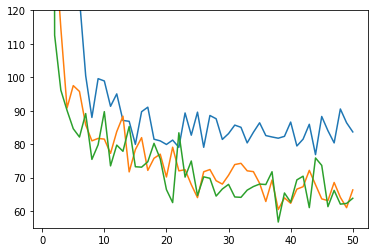

In [554]:
px = np.linspace(1, 50, 50)
plt.ylim(55, 120)
#mp=naive, mp2=10 sample, mp3=10 sample with b v
plt.plot(px, mp, px, mp2, px, mp3)
plt.show()

In [ ]:
train_op = StTh(loss_y)
stl = train(train_op)

In [ ]:
train_op = LR(h1, sh1, loss, loss_y)
lhr = train(train_op)

In [ ]:
train_op = NVIL(x, h1, sh1, loss, loss_y)
nv = train(train_op)

In [ ]:
train_op = VI(h1, sh1, loss, loss_y)
vii = train(train_op)

In [ ]:
px = np.linspace(1, 50, 50)
plt.ylim(55, 120)
plt.plot(px, lhr, px, mp, px, nv, px, vii)
plt.show()